In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

# Visualize the data

In [2]:
def ndarray_description(x):
    """Quick information on NDArrays."""
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [3]:
data = loadmat('data/ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [4]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]

print('X_train', ndarray_description(X_train))
print('y_train', ndarray_description(y_train))
print('Xval', ndarray_description(Xval))
print('yval', ndarray_description(yval))

X_train shape: (12, 2), min: -48.058829452570066, max: 37.49218733199513
y_train shape: (12, 1), min: 1.1732566787564553, max: 36.83795516371235
Xval shape: (21, 2), min: -50.01324364549543, max: 46.28236901853893
yval shape: (21, 1), min: -4.387382739157175e-05, max: 52.781927979043786


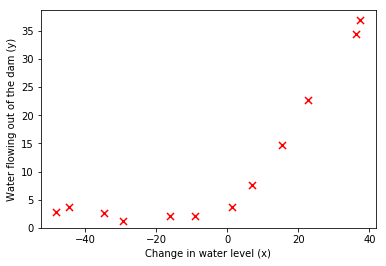

In [5]:
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(bottom=0);

# Linear Regression

In [6]:
def linear_regression_cost(theta, X, y, reg):
    """Vectorized cost function.
    
    :param numpy.ndarray theta: 2x1 parameter values
    :param numpy.ndarray X: 12 examples (rows) with 2 input values
    :param numpy.ndarray y: 12 examples (rows) with 1 result
    :param int reg: lambda value
    """
    m = y.size
    h = X.dot(theta)
    J = (1/(2*m))*np.sum(np.square(h-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    return J

In [8]:
def linear_regression_gradient(theta, X, y, reg):
    """Vectorized gradient function.
    
    :param numpy.ndarray theta: 2x1 parameter values
    :param numpy.ndarray X: 12 examples (rows) with 2 input values
    :param numpy.ndarray y: 12 examples (rows) with 1 result
    :param int reg: lambda value
    """
    m = y.size
    h = X.dot(theta.reshape(-1, 1))
    grad = (1/m)*(X.T.dot(h-y)) + (reg/m)*np.r_[[[0]], theta[1:].reshape(-1, 1)]
    return grad.flatten()

In [10]:
initial_theta = np.ones((X_train.shape[1], 1))
cost = linear_regression_cost(initial_theta, X_train, y_train, 0)
gradient = linear_regression_gradient(initial_theta, X_train, y_train, 0)
print(cost)
print(gradient)

303.9515255535976
[-15.30301567 598.16741084]


## scipy.optimize minimize

In [18]:
def train_linear_regression(X, y, reg):
    """Use scipy's minimize function to find optimal parameter values.
    
    :param numpy.ndarray X: 12 examples (rows) with 2 input values
    :param numpy.ndarray y: 12 examples (rows) with 1 result
    :param int reg: lambda value
    """
    # Not sure why init of ones returns an error...
#     initial_theta = np.ones((X.shape[1], 1))  # 2x1
    initial_theta = np.array([[15], [15]])
    res = minimize(linear_regression_cost, initial_theta, args=(X, y, reg), method=None,
                   jac=linear_regression_gradient, options={'maxiter': 5000})
    return res

In [19]:
fit = train_linear_regression(X_train, y_train, 0)
fit

      fun: 1604.4002999186632
 hess_inv: array([[1.03142187, 0.00617881],
       [0.00617881, 0.001215  ]])
      jac: array([ 3.4243719e-12, -5.7042134e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([13.08790351,  0.36777923])

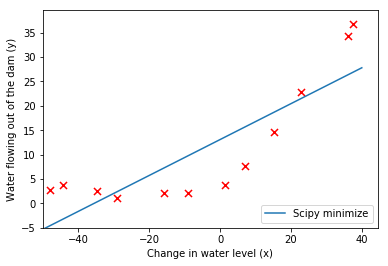

In [25]:
plt.plot(np.linspace(-50, 40), (fit.x[0] + (fit.x[1]*np.linspace(-50, 40))), label='Scipy minimize')
plt.scatter(X_train[:, 1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(bottom=-5)
plt.xlim(left=-50)
plt.legend(loc=4);

## sklearn.linear_model LinearRegression
Try using the LinearRegression model from sklearn. This way does not require a cost or gradient function.

In [22]:
regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train.ravel())
print(regr.coef_)
print(linear_regression_cost(regr.coef_, X_train, y_train, 0))

[13.08790351  0.36777923]
1604.4002999211034


# Learning Curves

In [27]:
def learning_curve(X, y, Xval, yval, reg):
    """Calculate the error for subsets of training and cross validation examples.
    
    :param numpy.ndarray X: 12 examples (rows) with 2 input values
    :param numpy.ndarray y: 12 examples (rows) with 1 result
    :param numpy.ndarray Xval: 21 examples (rows) with 2 input values
    :param numpy.ndarray yval: 21 examples (rows) with 1 result
    :param int reg: lambda value
    """
    m = y.size  # 12
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    # 0 - 12
    for i in np.arange(m):
        res = train_linear_regression(X[:i+1], y[:i+1], reg)
        error_train[i] = linear_regression_cost(res.x, X[:i+1], y[:i+1], reg)
        error_val[i] = linear_regression_cost(res.x, Xval, yval, reg)
    
    return error_train, error_val

In [29]:
t_error, v_error = learning_curve(X_train, y_train, Xval, yval, 0)
print('t_error', ndarray_description(t_error))
print('v_error', ndarray_description(v_error))

t_error shape: (12, 1), min: 8.874685183736383e-31, max: 1604.4002999186632
v_error shape: (12, 1), min: 2778.991373616289, max: 8535.691204951885


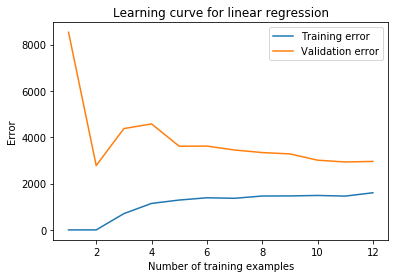

In [30]:
plt.plot(np.arange(1, 13), t_error, label='Training error')
plt.plot(np.arange(1, 13), v_error, label='Validation error')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();